<a href="https://colab.research.google.com/github/mannanoyed/Web-Element-object-detection/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Banao task 3
### Image Captioning
`Mann Vishnoi`

GOAL : AI model that can understand the visual information displayed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import numpy as np
import tensorflow as tf
from PIL import Image

# DATASET FROM KAGGLE

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d adityajn105/flickr8k

 98% 1.01G/1.04G [00:03<00:00, 273MB/s]
100% 1.04G/1.04G [00:04<00:00, 276MB/s]


In [7]:
!unzip flickr8k.zip


Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [8]:
captions = pd.read_csv('captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [9]:
print('Datatset shape:',captions.shape)

Datatset shape: (40455, 2)


## FEATURE ENGINEERING

In [10]:

captions['image'] = captions['image'].apply(
    lambda x: f'/content/Images/{x}')

In [11]:
inception_v3 = tf.keras.applications.InceptionV3(
    weights = 'imagenet',
    include_top= False
)

87910968/87910968 [==============================] - 1s 0us/step


## IMAGE PRE-PROCESSING

In [12]:
def load_image(img_path):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.keras.layers.Resizing(299,299)(img)
  img = img / 255
  return img

In [13]:
def feature_ext(img_path):
  img = load_image(img_path)
  img = tf.expand_dims(img, axis=0)
  feature_vector = inception_v3(img)
  return img, feature_vector


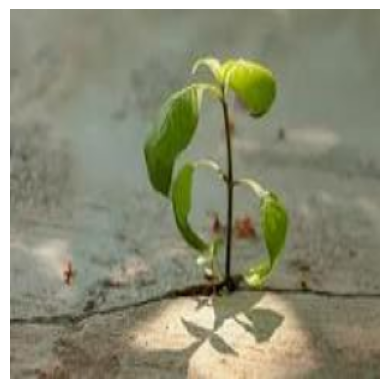


Input image size     : (1, 299, 299, 3)
Feature vector size  : (1, 8, 8, 2048)


In [14]:
img, feature_vector = feature_ext('/content/download.jpg')
plt.imshow(np.squeeze(img, axis=0))
plt.axis('off')
plt.show()


print()
print('Input image size     :', img.shape)
print('Feature vector size  :', feature_vector.shape)

#TEXT PRE-PROCESSING

In [15]:
type(captions['caption'].iloc[3])

str

In [16]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub('\s+',' ', text)
  text = text.strip()
  text = ' [start]' + text + ' [end]'

  return text

In [17]:

captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/Images/1000268201_693b08cb0e.jpg,[start]a child in a pink dress is climbing up...
1,/content/Images/1000268201_693b08cb0e.jpg,[start]a girl going into a wooden building [end]
2,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl climbing into a wooden p...
3,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl climbing the stairs to h...
4,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl in a pink dress going in...


In [18]:
MAX_LENGTH = 42
VOCAB_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [19]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)


tokenizer.adapt(captions['caption'])

In [20]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_endec.file', 'wb'))


In [21]:
# to convert word to index and index to word

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

# SPLITTING TEST AND VALIDATION DATASET

In [22]:
import collections
import random

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [23]:
captions.head()

,image,caption
0,/content/Images/1000268201_693b08cb0e.jpg,[start]a child in a pink dress is climbing up...
1,/content/Images/1000268201_693b08cb0e.jpg,[start]a girl going into a wooden building [end]
2,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl climbing into a wooden p...
3,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl climbing the stairs to h...
4,/content/Images/1000268201_693b08cb0e.jpg,[start]a little girl in a pink dress going in...


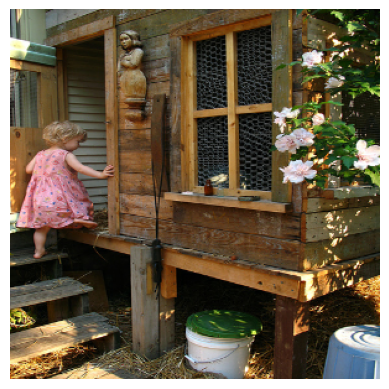


Input image size     : (1, 299, 299, 3)
Feature vector size  : (1, 8, 8, 2048)


In [24]:
img, feature_vector = feature_ext(captions['image'].iloc[0])
plt.imshow(np.squeeze(img, axis=0))
plt.axis('off')
plt.show()


print()
print('Input image size     :', img.shape)
print('Feature vector size  :', feature_vector.shape)

In [25]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

# LOAD DATA

In [26]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [27]:
## MAPPING IMAGES TO DATAFRAME index

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [28]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

## GETTING INCEPTION cv model from tensorflow

In [29]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [30]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [31]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [32]:
# TENOSR SHAPE

Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 42, 512])

In [33]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [34]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [35]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [36]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [37]:
history = caption_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
1012/1012 [==============================] - 360s 334ms/step - loss: 4.8727 - acc: 0.1418 - val_loss: 4.2159 - val_acc: 0.2691
Epoch 2/5
1012/1012 [==============================] - 303s 297ms/step - loss: 3.8776 - acc: 0.2855 - val_loss: 3.8191 - val_acc: 0.3092
Epoch 3/5
1012/1012 [==============================] - 300s 291ms/step - loss: 3.5529 - acc: 0.3203 - val_loss: 3.6977 - val_acc: 0.3206
Epoch 4/5
1012/1012 [==============================] - 298s 291ms/step - loss: 3.3747 - acc: 0.3376 - val_loss: 3.6285 - val_acc: 0.3279
Epoch 5/5
1012/1012 [==============================] - 331s 322ms/step - loss: 3.2224 - acc: 0.3526 - val_loss: 3.5696 - val_acc: 0.3383


In [38]:
idx2word(2).numpy().decode('utf-8')

'[end]'

In [44]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: dogs are running through the grass



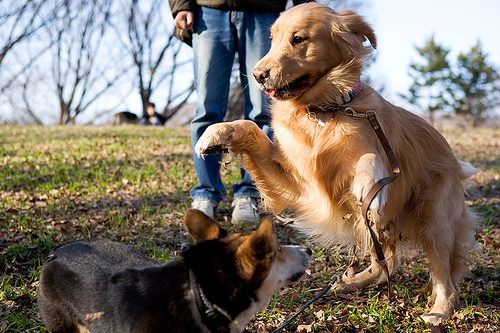

In [51]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: in a blue shirt and blue shirt is standing on a bench



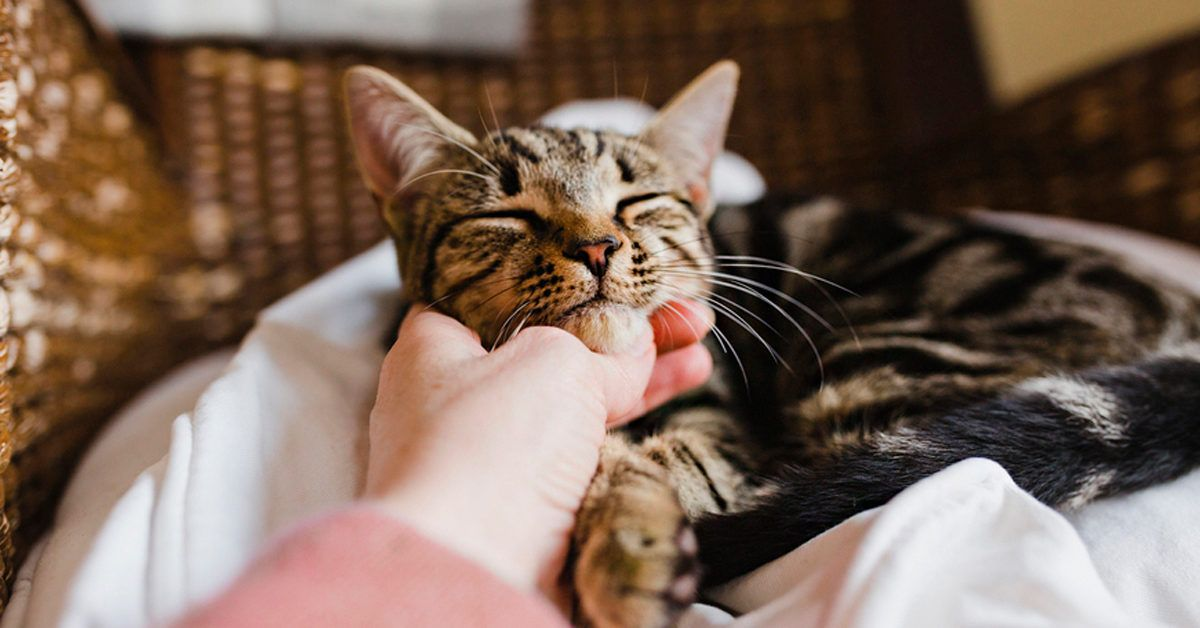

In [56]:
import requests
url = "https://media.post.rvohealth.io/wp-content/uploads/2020/07/petting_pet_cat-1200x628-facebook-1200x628.jpg"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)
print()
im

In [42]:
# caption_model.save_weights('image_captioning_transformer_weights.h5')

# if not load_weights:
#     from google.colab import drive
#     drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())

## REFERENCES:
- [INCEPTION](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3)
- [TRANSFORMERS](https://www.tensorflow.org/text/tutorials/transformer)